# Supervised Multivariate Normal Learning (MVN Regression)

In supervised learning, the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$.
Regression typically means the output $Y$ takes continuous values.  
$Y$ has $D$ dimensions and $X$ has $Q$ dimensions.

This builds on the single variable example in: http://edwardlib.org/tutorials/supervised-regression

We demonstrate with an example in Edward. A webpage version is not available at the moment


In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal, MultivariateNormalTriL

plt.style.use('ggplot')

## Data

Simulate training and test sets of $100$ data points, $2$ $Y$ variables and $10$ $X$ factors (one of which is a constant value). 

They comprise of pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$Y_n\in\mathbb{R}^{2}$. They have a linear dependence with normally distributed and correlated noise $\Sigma$.

In [2]:
def build_toy_dataset(N, output_shape, input_shape, true_weights, true_cov,  add_const = False):
    """
    model: Y = XB + e  
    where: Y is (N, output_shape), X is (N, input_shape), 
           B is (input_shape, output_shape) and e is (N, output_shape),
           e_i ~ N(0, cov), cov is (output_shape, output_shape) and positive, semi-definite

    if add_const: will set the last column of X to constant at the true_weights[-1] value
    """    
    import numpy as np
    
    if output_shape > 1:
        assert (output_shape, output_shape) == true_cov.shape, "true_cov has wrong shape"
        assert (input_shape, output_shape) == true_weights.shape, "true_weights has wrong shape"
    if add_const:
        assert input_shape > 0, "if add_const is true"
    
    # Could just call errors = np.random.multivariate_normal(0, cov, N)    
    L = np.linalg.cholesky(true_cov)
    e = np.random.standard_normal((output_shape,N))
    errors = np.dot(L,e).T
    
    # Create X
    if add_const:
        X = np.hstack([np.random.normal(0.0, 2.0, size=(N, input_shape-1)), np.ones((N,1))])
    else:
        X = np.random.normal(0.0, 2.0, size=(N, input_shape))
    
    # Calculate Y
    Y = np.dot(X, true_weights) + errors
    
    return X, Y, errors

In [3]:
#ed.set_seed(42)

N = 1000  # number of data points
D = 2    # number of target variables
Q = 5   # number of features

true_weights = np.random.randn(Q,D) * 10
true_cov = np.array([[1,0.75],[0.75 , 2]])
X_train, Y_train, Errors_train = build_toy_dataset(N, D, Q, true_weights, true_cov, add_const = True)
X_test, Y_test, Errors_test = build_toy_dataset(N, D, Q, true_weights, true_cov, add_const = True)

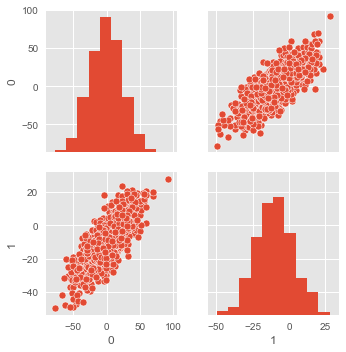

In [4]:
import seaborn as sns
import pandas as pd
sns.pairplot(pd.DataFrame(Y_test))

## Model

Posit the model as Bayesian linear regression (Murphy, 2012).
It assumes a linear relationship between the inputs
$\mathbf{x}\in\mathbb{R}^Q$ and the outputs $Y\in\mathbb{R}^D$.

For a set of $N$ data points $(\mathbf{X},\mathbf{Y})=\{(\mathbf{x}_n, y_n)\}$,
the model posits the following distributions:

\begin{align*}
  p(\mathbf{B})
  &=
  \text{Normal}(\mathbf{\mu_B} \mid \mathbf{0}, \sigma_B^2\mathbf{I}),
  \\[1.5ex]
  p(\mathbf{\Sigma_Y})
  &=
  \text{InverseWishart}(S, \nu),
  \\[1.5ex]
  p(\mathbf{Y} \mid \mathbf{B}, \mathbf{X}, \mathbf{\Sigma_Y})
  &=
  \prod_{n=1}^N
  \text{Normal}(Y_n \mid \mathbf{x}_n^\top\mathbf{B}, \Sigma_Y).
\end{align*}

The latent variables are the linear model's weights $\mathbf{B}$
Assume $\sigma_B^2$ is a known prior variances and $\Sigma_Y$ is a
known likelihood variance. 

The mean of the likelihood is given by a
linear transformation of the inputs $\mathbf{x}_n$.

Let's build the model in Edward, fixing $\mu_B=0$, $\sigma_B=1$ and $\Sigma_Y$ to the true value.

In [5]:
""" Single Variable Code
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))
"""

' Single Variable Code\nX = tf.placeholder(tf.float32, [N, D])\nw = Normal(loc=tf.zeros(D), scale=tf.ones(D))\nb = Normal(loc=tf.zeros(1), scale=tf.ones(1))\ny = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))\n'

In [6]:
X = tf.placeholder(tf.float32, [N, Q], name="X")
Y = tf.placeholder(tf.float32, [N, D], name="Y")

# Beta Priors
beta_loc = tf.zeros((Q, D), dtype=tf.float32, name="Beta_loc")
beta_scale = tf.ones((Q, D), dtype=tf.float32, name="Beta_scale")
B = Normal(loc=beta_loc, scale=beta_scale, name="Beta")

# Covar Priors
# Create Lower Triangular Prior for MultivariateNormalTriL
scale = tf.cholesky(tf.convert_to_tensor(true_cov, tf.float32), name="Y_scale_tril")
mvn_scale = tf.tile(tf.reshape(scale, [1,2,2]), [N,1,1], name="Y_scale_tril_tiled")

# Model multivariate normal (do I add sample_shape=N to this?)

Y = MultivariateNormalTriL(loc = tf.matmul(X,B), scale_tril=mvn_scale, name = "Y_model")
#Y = MultivariateNormalTriL(loc = ed.dot(X, B), scale_tril=mvn_scale, name = "Y_model")

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

We now turn to inferring the posterior using variational inference.
Define the variational model to be a fully factorized normal across
the weights.

In [7]:
# Posterior Variables
qB_loc = tf.Variable(tf.random_normal([Q,D], dtype=tf.float32), name='B_posterior_loc')
#qb_scale_normal = tf.Variable(tf.random_normal([Q,D]), dtype=tf.float32, name='B_posterior_scale_normal' )
#qB_scale = tf.nn.softplus(qb_scale_normal, name='B_posterior_scale')
qB_scale = tf.ones((Q, D), dtype=tf.float32, name="Beta_scale") / 100.0
#qB = Normal(loc = qB_loc, scale = qB_scale, name = "B_posterior")
qB = Normal(loc = qB_loc, scale = qB_scale, name = "B_posterior")

In [8]:
tf.trainable_variables()

[<tf.Variable 'B_posterior_loc:0' shape=(5, 2) dtype=float32_ref>]

Run variational inference with the Kullback-Leibler divergence, using 
$250$ iterations and $5$ latent variable samples in the algorithm.

In [9]:
import datetime, os
logdir_base = 'C:\\Users\skruz\\temp\\tensorflow\\MLR\\'
log_run = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%dT%H%M%SZ")
logdir = os.path.join(logdir_base, log_run)

X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

In [10]:
#inference = ed.KLqp({B: qB}, data={X: X_train, Y: Y_train})
#inference = ed.KLqp({B: qB}, data={X: X_train, Y: Y_train})
#inference.run(n_samples=5, n_iter=250, logdir=logdir)

In [11]:
inference = ed.KLqp({B: qB}, data={X: X_train, Y: Y_train})

inference.initialize(n_samples=5, n_iter=1000, logdir=logdir)
tf.global_variables_initializer().run()

results = []

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  results.append(info_dict)

inference.finalize()

1000/1000 [100%] ██████████████████████████████ Elapsed: 344s | Loss: 3219.227


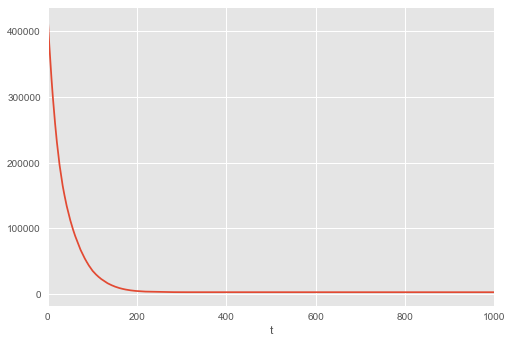

In [12]:
import pandas as pd
pd.DataFrame(results).set_index('t')['loss'].plot()

# Review Results

In [13]:
# Fit using normal linear regression
Y_test

array([[-27.0076986 , -28.85050134],
       [ -1.63059601,   0.12920997],
       [ 23.80945563,   7.56741813],
       ..., 
       [-24.2113206 , -26.68214166],
       [ 22.58306047,  -3.56328246],
       [-10.86600054,  -1.24176723]])

In [14]:
from sklearn.linear_model import LinearRegression
m = LinearRegression(fit_intercept=False)
m.fit(X=X_train, y=Y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

This is absolute deviations from targets


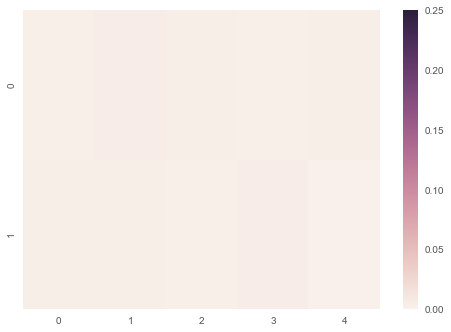

In [15]:
import seaborn as  sns
print("This is absolute deviations from targets")
sns.heatmap(np.abs((true_weights.T - m.coef_) / true_weights.std()), vmin=0.0, vmax=0.25)

What did the model converge to?

This is the fitted absolute deviations from targets


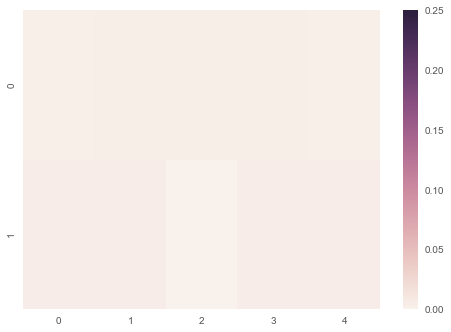

In [16]:
mean_betas = qB.mean().eval()
print("This is the fitted absolute deviations from targets")
sns.heatmap(np.abs((true_weights.T - mean_betas.T) / true_weights.std()), vmin=0.0, vmax=0.25)

In [17]:
def visualize_dists(w, qw, actual=None, n_samples=1000, figsize=None):
    """
    Creates a grid of histograms of samples from two distributions 'w' and 'qw'
    Optionally creates a red vertical line for each value in 'acutal'
        
    Args:
        w:  the prior variable with an ability to sample  
        qw:  the posterior variable with the same dimensions as w
        actual:  a list-like of known true values, has the same dimension as w
        n_samples (int): the number of samples, default = 1000 
        figsize (tuple): a tuple of the figure size, default is (20, 2*D) where D is the dimension of w 

    Returns:
        matplotlib.figure: A gr
        
    Usage:
        visualize_dists(w, qw, actual=[0.1, 0.0, 0.23, 0.5, 0.3], n_samples=1000)
    """
    import seaborn as sns
    import matplotlib.pylab as plt
    
    w_samples = w.sample(n_samples).eval()
    qw_samples = qw.sample(n_samples).eval()
    
    w_samples = np.reshape(w_samples, [n_samples, np.product(w_samples.shape[1:])])
    qw_samples = np.reshape(qw_samples, [n_samples, np.product(qw_samples.shape[1:])])
    
    actual = actual.flatten()

    D = w_samples.shape[1]

    if figsize is None:
        figsize = (20, D * 2)

    fig = plt.figure(figsize=figsize)
    axes = []
    for i in range(D):
        if i == 0:
            ax = fig.add_subplot(np.ceil(D / 2), 2, i + 1)
        else:
            ax = fig.add_subplot(np.ceil(D / 2), 2, i + 1)
        sns.distplot(w_samples[:, i], kde=False, rug=False, ax=ax, color='grey')
        sns.distplot(qw_samples[:, i], kde=False, rug=False, ax=ax, color='b')
        ax.set_title('variable {}'.format(i))
        axes.append(ax)

    if not actual is None:
        for i in range(D):
            ymin, ymax = ax.get_ylim()
            axes[i].vlines([actual[i]], ymin=ymin, ymax=ymax, color='r')

    fig.tight_layout()
    fig.suptitle('prior vs posterier weight samples')
    return fig


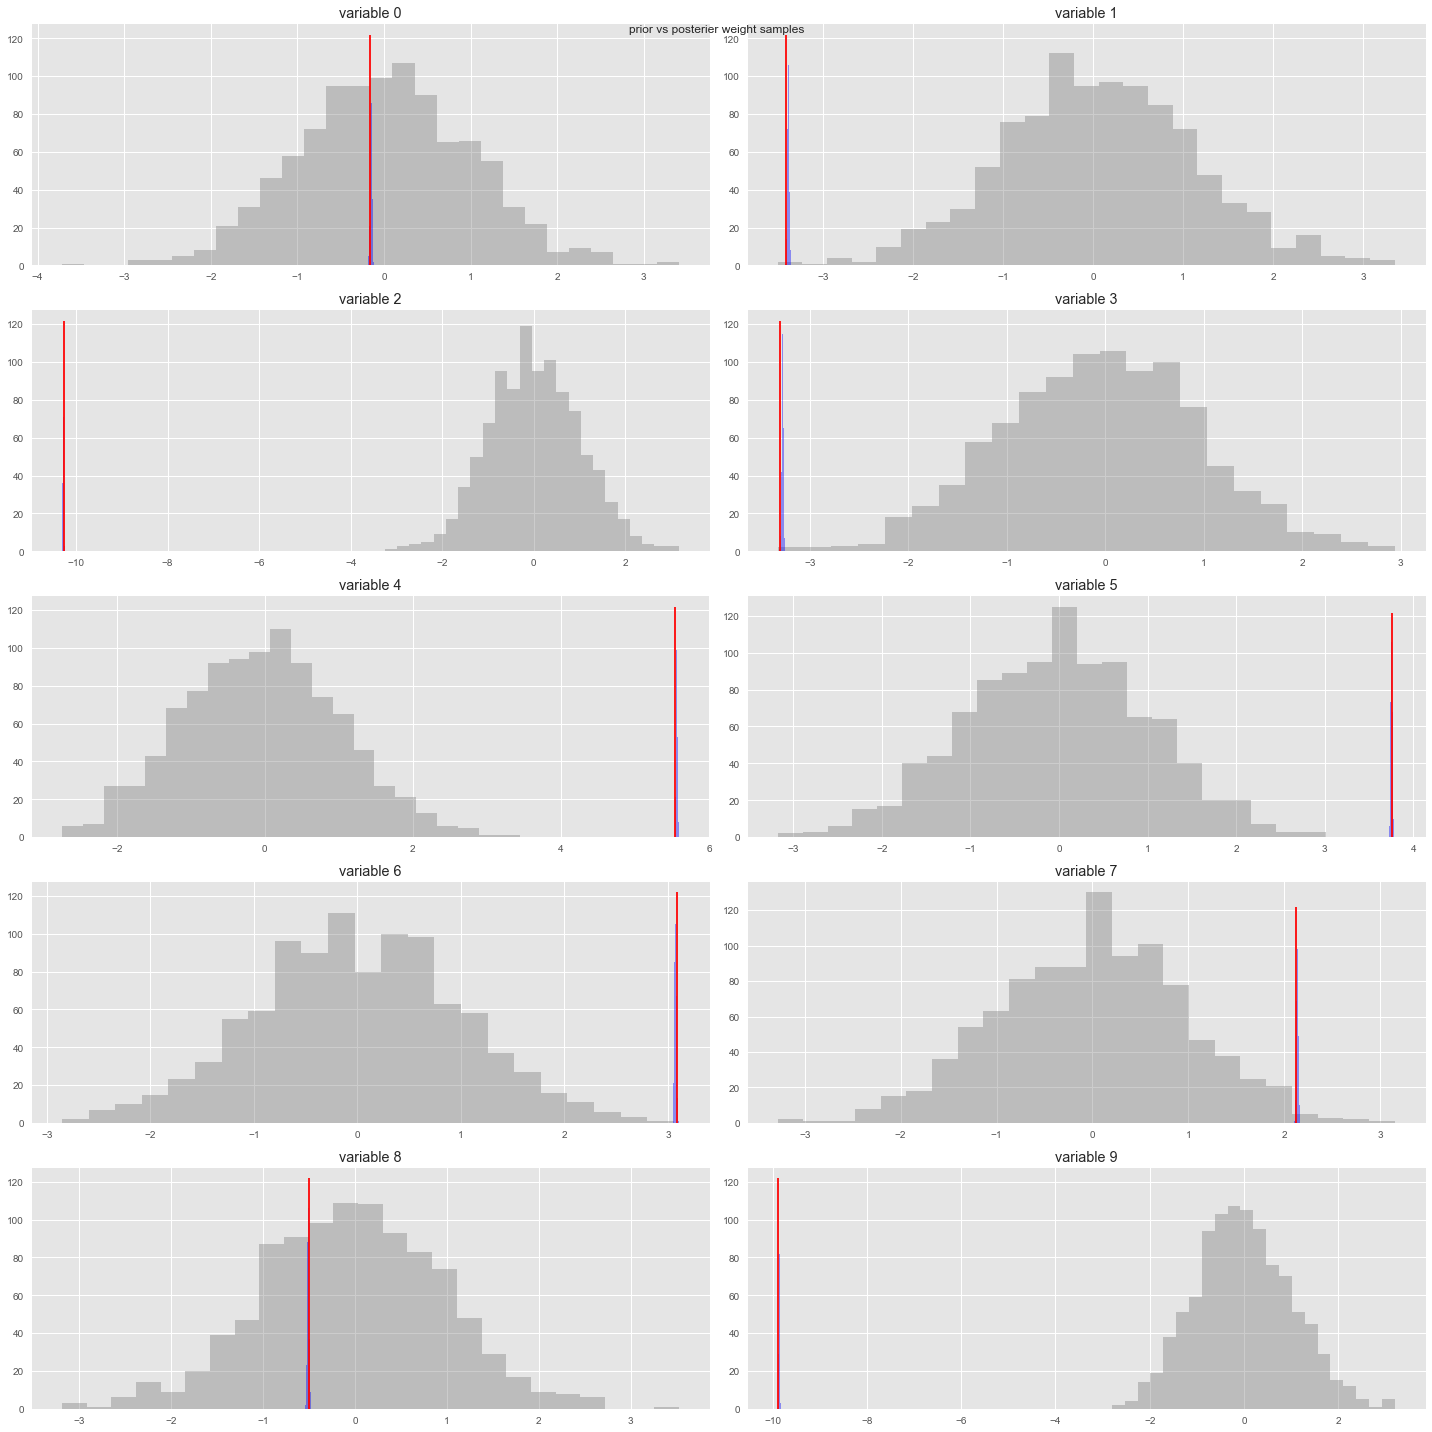

In [18]:
_ = visualize_dists(B, qB, actual=true_weights, n_samples=1000)

In [19]:
1/0

ZeroDivisionError: division by zero

In [ ]:
graph = tf.get_default_graph()

In [ ]:
graph.get_all_collection_keys()

In [ ]:
n = graph.get_collection('variables')[0]
print(n.name)
graph.get_operations()

In [ ]:
1/0
inference = ed.KLqp({B: qB}, data={X: X_train, Y: Y_train})

results = []
for optimizer in ['gradientdescent', 'adadelta','adagrad','momentum', 'adam','ftrl','rmsprop']:
    print("optimizer: {}".format(optimizer))
    inference.initialize(n_samples=5, n_iter=100, logdir=logdir, optimizer = optimizer, var_list=[qB_loc,qB_scale])

    tf.global_variables_initializer().run()

    for _ in range(inference.n_iter):
      info_dict = inference.update()
      info_dict['optimizer'] = optimizer
      results.append(info_dict)
      inference.print_progress(info_dict)

    inference.finalize()

In [ ]:
# TODO: Check trainable_variables should only have var_list=[qB_loc,qB_scale]
# TODO: Solve NotImplementedError: ('Trying to optimize unsupported type ', <tf.Tensor B_posterior_scale':0' shape=(5, 2) dtype=float32
tf.trainable_variables()

In [ ]:
1/0

In [ ]:
sigma = ed.models.Gamma(10.0,100.0)
data = ed.models.Normal(loc=0.0, scale=sigma)

sess=tf.Session()

N=10000
with sess.as_default():
    x_train = data.sample(N).eval()

In [ ]:
sigma = ed.models.Gamma(1.0,1.0)
x = ed.models.Normal(loc=tf.zeros([N]), scale=sigma*tf.ones([N]))

#qsigma = ed.models.GammaWithSoftplusConcentrationRate(tf.Variable(1.0), tf.Variable(1.0))

#from edward.models import TransformedDistribution
ds = tf.contrib.distributions
qlognormal = ds.TransformedDistribution(
    distribution=ds.Normal(loc=tf.Variable(0.0), scale=tf.Variable(1.0)),
    bijector=ds.bijectors.Inline(
      forward_fn=tf.exp,
      inverse_fn=tf.log,
      inverse_log_det_jacobian_fn=(
        lambda y: -tf.reduce_sum(tf.log(y), axis=-1)),
    name="LogNormalTransformedDistribution"))


# INFERENCE
qlognormal = TransformedDistribution(base_dist_cls=Normal, mu=tf.zeros(1), sigma=tf.ones(1), transform=tf.log,
  inverse=tf.exp)


inference = ed.KLqp({sigma: qlognormal},data={x: x_train})
inference.run(n_iter = 10000)

In [ ]:
print(.__doc__)

In [ ]:
[qsigma.parameters['concentration'].eval(),qsigma.parameters['rate'].eval()]

In [ ]:
qx=ed.copy(x,{sigma:qsigma})
plt.hist(x_train,alpha=0.5, color='grey')
plt.hist(qx.sample().eval(), color='r')
plt.show()

In [ ]:
inference = ed.Inference({B: qB}, data={X: X_train, Y: Y_train})
inference.run(n_samples=5, n_iter=250, logdir=logdir)

In [ ]:
inference = ed.KLqp({B: qB}, data={X: X_train, Y: Y_train})
inference.initialize()

tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)

inference.finalize()

In [ ]:
info_dict

In this case `KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp).

## Criticism

A standard evaluation for regression is to compare prediction accuracy on
held-out "testing" data. We do this by first forming the posterior predictive
distribution.

In [ ]:
Y_post = ed.copy(Y, {B: qB})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

With this we can evaluate various quantities using predictions from
the model (posterior predictive).

In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, Y_post: Y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, Y_post: Y_test}))

The trained model makes predictions with low error
(relative to the magnitude of the output).

We can also visualize the fit by comparing data generated with the
prior to data generated with the posterior (on the first feature
dimension).

In [ ]:

Y_samples.shape

In [ ]:
tf.summary.get_summary_description(Y_post)

In [ ]:
Y_samples = Y.sample(50).eval()
Y_post_samples = Y_post.sample(50).eval()
t = np.random.randint(0,N)
for i in range(D):
    fig = plt.figure(); ax=fig.add_subplot(111)
    pd.DataFrame(Y_samples[:,t,i],columns=['Y_{}'.format(i)]).hist(ax=ax, color='grey')
    pd.DataFrame(Y_post_samples[:,t,i],columns=['Y_{}'.format(i)]).hist(ax=ax, color='blue')
    lims = ax.get_ylim()
    ax.vlines([Y_train[t,i]], ymin=lims[0], ymax=lims[1])

In [ ]:
B_samples = B.sample(50).eval()
B_post_samples = qB.sample(50).eval()
print(B_samples.shape, B_post_samples.shape)

In [ ]:
t = np.random.randint(0,N)
fig = plt.figure();
axes = []
index = 0
for i in range(D):
    for j in range(Q):
        axes.append(fig.add_subplot(D,Q,index+1))
        pd.DataFrame(B_samples[:,j,i],columns=['Y_{}'.format(i)]).hist(ax=axes[-1], color='grey')
        pd.DataFrame(B_post_samples[:,j,i],columns=['Y_{}'.format(i)]).hist(ax=axes[-1], color='blue')
        index += 1
index = 0
for i in range(D):
    for j in range(Q):
        lims = ax.get_ylim()
        axes[index].vlines([true_weights[j,i]], ymin=lims[0], ymax=lims[1], color='r')
        index += 1
        

# Visualize the Edward Inference Graph

In [ ]:
#sess = ed.get_session()
#file_writer = tf.summary.FileWriter('C:\\Users\skruz\\temp\\tensorflow\\', sess.graph)


Launch Tensorboard by calling
    > python -m tensorflow.tensorboard --logdir=C:\Users\skruz\temp\tensorflow --host=localhost
    
Open URL: http://localhost:6006

In [ ]:
tmp = qB_loc.initialized_value

In [ ]:
tmp.get_values()